In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from utility_functions import insert_layer, intermediate_output,plot_intermediate,insert_STN,plot_fig
import tensorflow_addons as tfa

#projective transformation layer
from pers_layer import *


In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2022-09-13 21:11:44.618698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 21:11:44.619623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 21:11:44.620504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 21:11:44.647057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 21:11:44.648007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [4]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [6]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
train_images

<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [10]:
def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2022-09-13 21:11:57.277043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


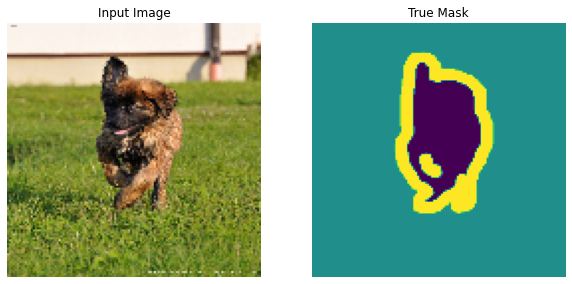

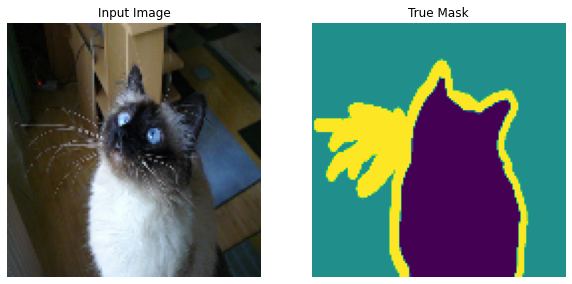

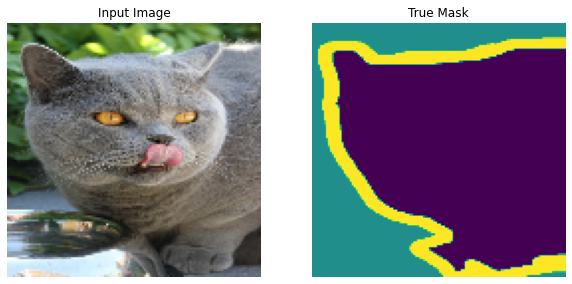

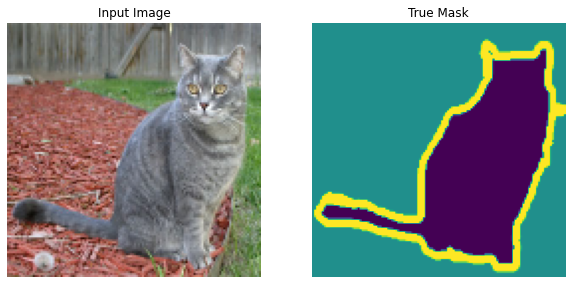

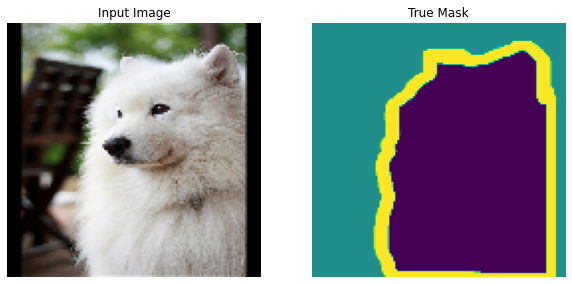

In [11]:
for images, masks in test_batches.take(5):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [12]:
def conv_single(inp, n, k):
    x = Conv2D(filters = n, kernel_size = (k, k), padding='same',activation = 'sigmoid')(inp)
    return x

#Two sequential 2D convolutional layers with batch normailization
def conv_double(inp, n, k = 3):
    x = Conv2D(filters = n, kernel_size = (k, k), padding = 'same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = n, kernel_size = (k, k), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# 2D transposed convolutional (Deconvolutional) layer
def conv_transpose(inp, n, k = 3, s = 2):
    x = Conv2DTranspose(filters = n, kernel_size = (k, k), strides = (s, s), padding = 'same')(inp)
    return x

# maxpool and a dropout for downsampoling
def max_pool(inp, dropout = 0.1):
    x = MaxPool2D(pool_size = (2, 2))(inp)
    x = Dropout(rate = dropout)(x)
    return x

In [13]:
class UNet_arch(Model):
    """ 
        U-Net architecture
    """
    def __init__(self,input_size,filters, proj=False):
        # define input layer
        inp = Input(input_size)
        
        
        # Projective layer
        if proj:
            conv_1 = conv_double(inp, filters * 1)
            
            sampling_size = (inp.shape[1],inp.shape[2])
            conv_1 = Projective_Layer(sampling_size)(conv_1) 
            
            
        elif proj==False:
            conv_1 = conv_double(inp, filters * 1)
       
        
        pool_1 = max_pool(conv_1)

        conv_2 = conv_double(pool_1, filters * 2)
        pool_2 = max_pool(conv_2)

        conv_3 =  conv_double(pool_2, filters * 4)
        pool_3 = max_pool(conv_3)

        conv_4 =  conv_double(pool_3, filters * 8)
        pool_4 = max_pool(conv_4)

        #middle part
        conv_5 =  conv_double(pool_4, filters * 16)
        

        # Expansive path(Decoder)
        up_6 = conv_transpose(conv_5, filters * 8)
        up_6 = concatenate([conv_4, up_6])
        conv_6 =  conv_double(up_6, filters * 8)

        up_7 = conv_transpose(conv_6, filters * 4)
        up_7 = concatenate([conv_3, up_7])
        conv_7 =  conv_double(up_7, filters * 4)

        up_8 = conv_transpose(conv_7, filters * 2)
        up_8 = concatenate([conv_2, up_8])
        conv_8 = conv_double(up_8, filters * 2)

        up_9 = conv_transpose(conv_8, filters * 1)
        up_9 = concatenate([conv_1, up_9])
        conv_9 =  conv_double(up_9, filters * 1)
        
        
        if proj:
         
            
            sampling_size = (conv_9.shape[1],conv_9.shape[2])
            conv_9 = Projective_Layer(sampling_size)(conv_9) 
        

        #Output
        output = conv_single(conv_9, 10, 1)

        super(UNet_arch, self).__init__(inputs = inp, outputs = output,name='unetModel')


In [14]:
unet = UNet_arch(input_size = (128,128,3),filters = 32, proj=False)
unet_proj = UNet_arch(input_size = (128,128,3),filters = 32, proj=True)

In [15]:
unet.summary()

Model: "unetModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [16]:
unet_proj.summary()

Model: "unetModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 32) 128         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 128, 32) 0           batch_normalization_18[0][0]     
__________________________________________________________________________________________

# Define Loss

In [17]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf



In [19]:
def dice_coef_10(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=10)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_10_loss(y_true, y_pred):
    '''
    Dice loss to minimize. 
    '''
    return 1 - dice_coef_10(y_true, y_pred)

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [21]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.1)


In [22]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=[dice_coef_10]) 

In [23]:
EPOCHS = 200
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE

In [24]:
VALIDATION_STEPS

114

In [27]:

history = unet.fit(train_batches, 
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=test_batches,
                          #callbacks=[DisplayCallback()]
)

Epoch 1/200


Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2022-09-07 22:11:17.341385: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


115/115 [==============================] - 13s 68ms/step - loss: 1.3994 - dice_coef_10: 0.2132 - val_loss: 2.0023 - val_dice_coef_10: 0.2159
Epoch 2/200
115/115 [==============================] - 8s 65ms/step - loss: 0.6620 - dice_coef_10: 0.3208 - val_loss: 0.9716 - val_dice_coef_10: 0.3124
Epoch 3/200
115/115 [==============================] - 7s 65ms/step - loss: 0.5016 - dice_coef_10: 0.3853 - val_loss: 1.0024 - val_dice_coef_10: 0.3724
Epoch 4/200
115/115 [==============================] - 8s 66ms/step - loss: 0.4401 - dice_coef_10: 0.4222 - val_loss: 0.5899 - val_dice_coef_10: 0.4236
Epoch 5/200
115/115 [==============================] - 8s 66ms/step - loss: 0.4011 - dice_coef_10: 0.4463 - val_loss: 0.4384 - val_dice_coef_10: 0.4475
Epoch 6/200
115/115 [==============================] - 8s 66ms/step - loss: 0.3686 - dice_coef_10: 0.4641 - val_loss: 0.4558 - val_dice_coef_10: 0.4710
Epoch 7/200
115/115 [==============================] - 8s 66ms/step - loss: 0.3512 - dice_coef_10: 

In [25]:
unet_proj.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=[dice_coef_10]) 

In [26]:
history2 = unet_proj.fit(train_batches, 
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=test_batches,
)

Epoch 1/200


Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2022-09-13 21:12:35.434365: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


115/115 [==============================] - 120s 971ms/step - loss: 1.0312 - dice_coef_10: 0.2750 - val_loss: 1.1190 - val_dice_coef_10: 0.3518
Epoch 2/200
115/115 [==============================] - 109s 952ms/step - loss: 0.5730 - dice_coef_10: 0.3852 - val_loss: 1.1004 - val_dice_coef_10: 0.4346
Epoch 3/200
115/115 [==============================] - 109s 953ms/step - loss: 0.4631 - dice_coef_10: 0.4409 - val_loss: 0.7041 - val_dice_coef_10: 0.4326
Epoch 4/200
115/115 [==============================] - 109s 953ms/step - loss: 0.4090 - dice_coef_10: 0.4754 - val_loss: 0.5288 - val_dice_coef_10: 0.5054
Epoch 5/200
115/115 [==============================] - 109s 953ms/step - loss: 0.3816 - dice_coef_10: 0.4990 - val_loss: 0.4900 - val_dice_coef_10: 0.5591
Epoch 6/200
115/115 [==============================] - 109s 956ms/step - loss: 0.3518 - dice_coef_10: 0.5177 - val_loss: 0.4068 - val_dice_coef_10: 0.5389
Epoch 7/200
115/115 [==============================] - 110s 958ms/step - loss: 0.3

In [30]:
# unet

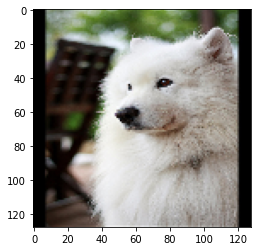

In [44]:
plt.imshow(sample_image)

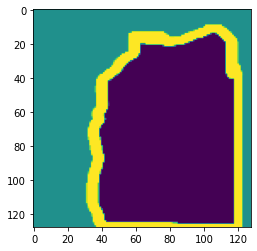

In [45]:
plt.imshow(sample_mask)

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [28]:
def show_predictions(model= unet,dataset=None, num=2):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

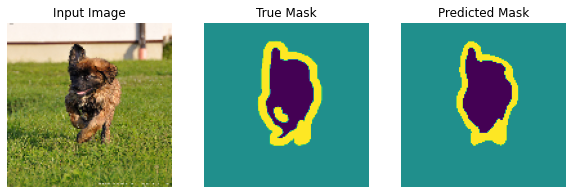

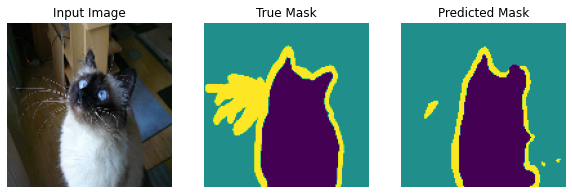

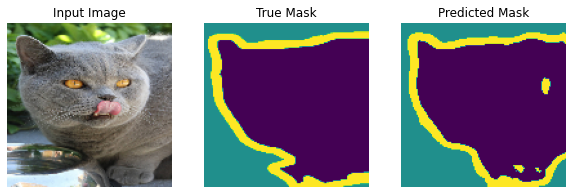

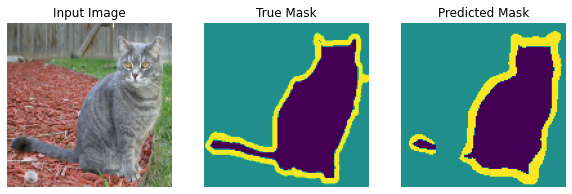

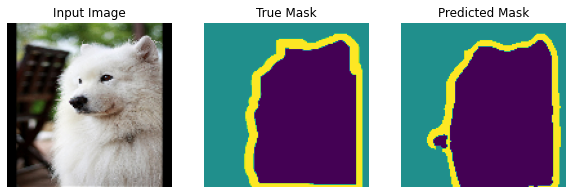

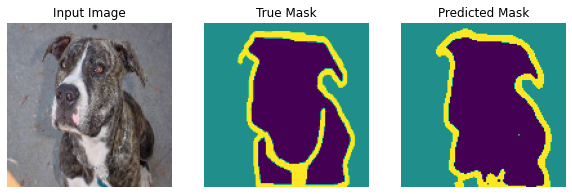

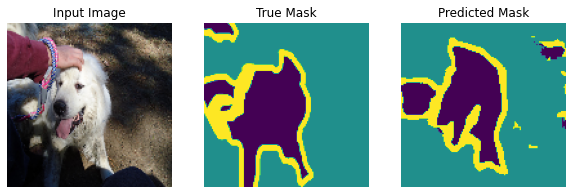

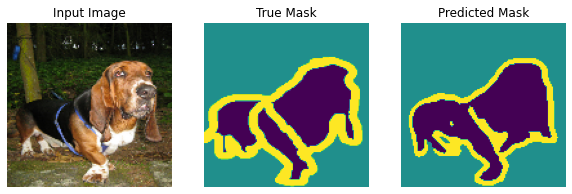

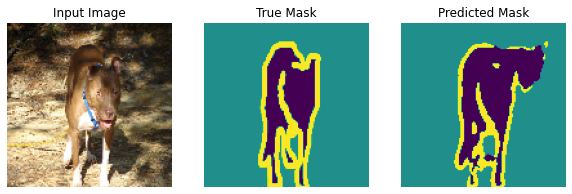

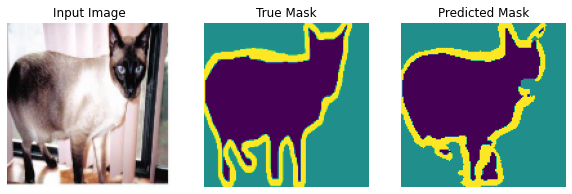

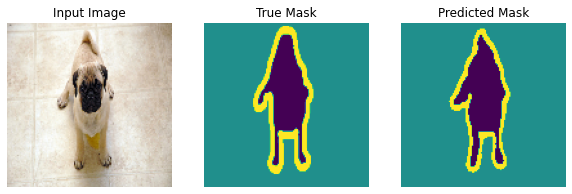

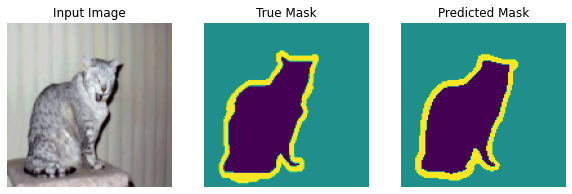

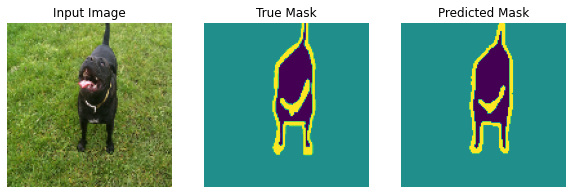

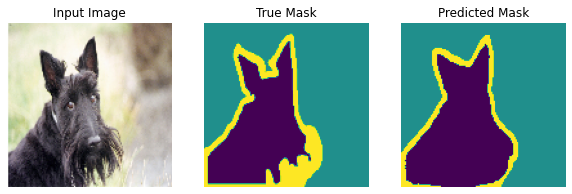

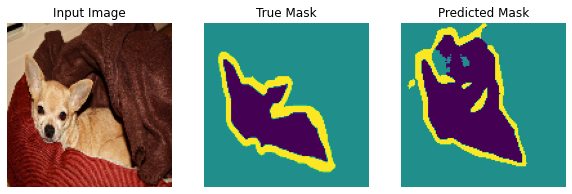

In [55]:
show_predictions(model=unet, dataset=test_batches,num=15)

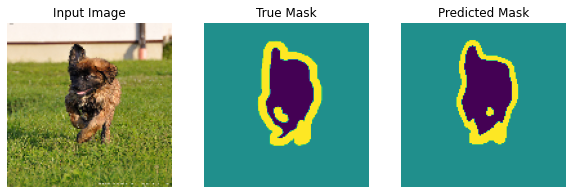

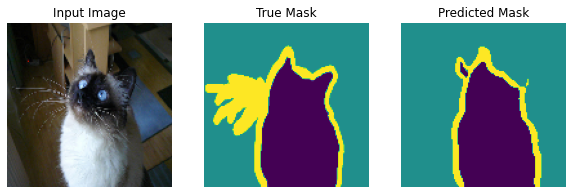

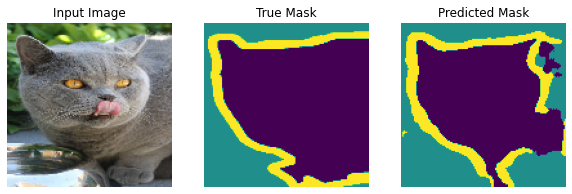

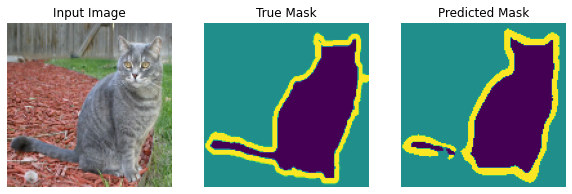

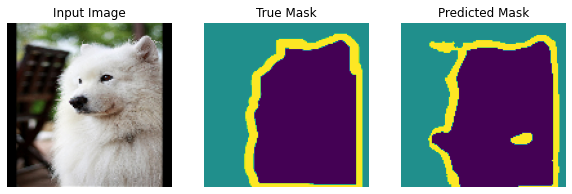

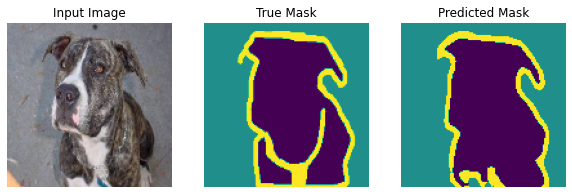

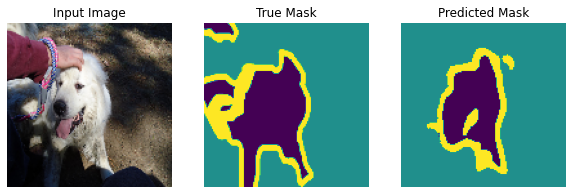

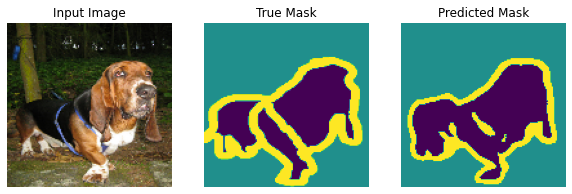

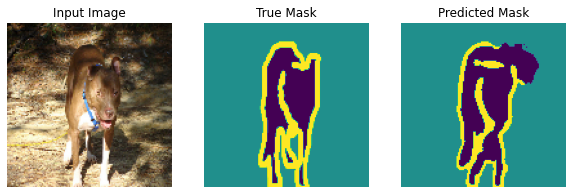

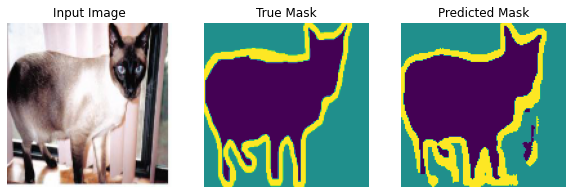

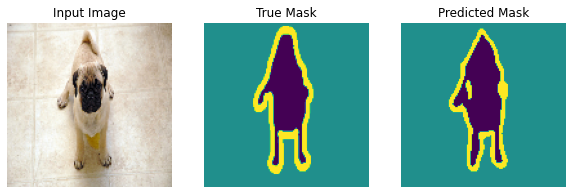

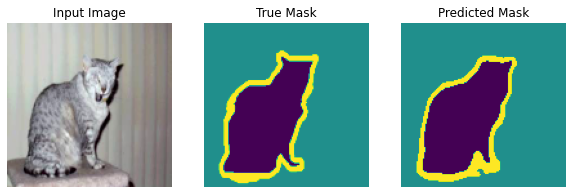

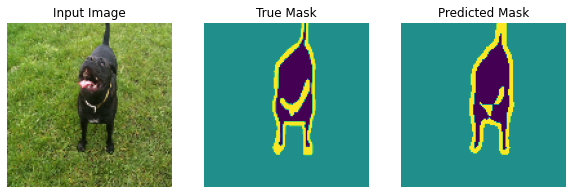

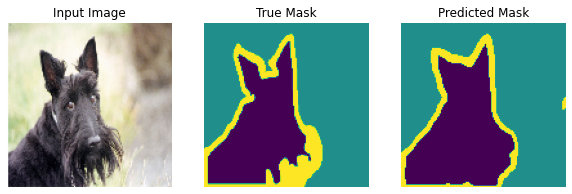

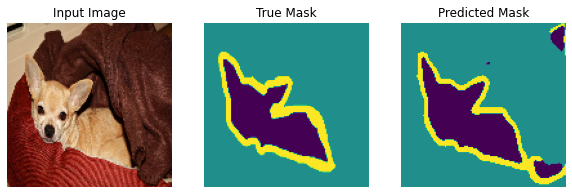

In [29]:
show_predictions(model=unet_proj, dataset=test_batches,num=15)